In [1]:
import pandas as pd
import time
import seaborn
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn import linear_model
import kernelml
import re

from ipyparallel import Client
rc = Client(profile='default')
dview = rc[:]

dview.block = True

with dview.sync_imports():
    #for some reason, aliases cannot be use
    import numpy
    import scipy

importing numpy on engine(s)
importing scipy on engine(s)


In [2]:
full = pd.read_csv('DATA/hb_training.csv')
test = pd.read_csv('DATA/hb_testing.csv')

def change_label(x):
    if x =='s':
        return 1
    else: 
        return 0
    
full['Label'] = full['Label'].apply(change_label)
EventId = test['EventId']
full.drop(['EventId'],axis=1,inplace=True)
test.drop(['EventId'],axis=1,inplace=True)
features = list(full.columns[:-2])
target = list(full.columns[-1:])

#randomly sample and split data
all_samples=full.index
ones = full[full[target].values==1].index
zeros = full[full[target].values==0].index
ones_rand_sample = np.random.choice(ones, size=int(len(ones)*0.5),replace=False)
zeros_rand_sample = np.random.choice(zeros, size=int(len(zeros)*0.5),replace=False)
rand_sample  = np.concatenate((ones_rand_sample,zeros_rand_sample))
np.random.shuffle(rand_sample)

test_sample = np.setdiff1d(all_samples,rand_sample)
valid = full.loc[test_sample,:]
train = full.loc[rand_sample,:]

In [3]:
class NNShapeHelper():

    def __init__(self,layer_shape,num_inputs,num_outputs):
        
        self.N_inputs = num_inputs
        self.N_outputs = num_outputs
        self.layer_shape = layer_shape
        self.N_layers = len(layer_shape)
        self.model_shape = []
        self.parameter_shape = []
        
    def get_N_parameters(self):
        
        self.model_shape.append(self.N_inputs)
        input_n_parameters = self.N_inputs*self.layer_shape[0]
        N =  input_n_parameters
        self.parameter_shape.append(input_n_parameters)
        
        for i in range(1,self.N_layers):
            layer_n_parameters = self.layer_shape[i-1]*self.layer_shape[i]
            self.model_shape.append(self.layer_shape[i])
            self.parameter_shape.append(layer_n_parameters)
            N += layer_n_parameters
            
        output_n_parameters = self.N_outputs*self.layer_shape[-1]
        N += output_n_parameters
        self.model_shape.append(self.N_outputs)
        self.parameter_shape.append(output_n_parameters)
        self.N_parameters = N
        return N

In [4]:
shapehelper = NNShapeHelper([10,len(features)],len(features),1)
num_parameters = shapehelper.get_N_parameters()
shapes = [shapehelper.model_shape,shapehelper.parameter_shape]
shapes

[[30, 30, 1], [300, 300, 30]]

In [5]:
def autoencoder_function(X,y,w_tensor,args,predict=False):
    #can't be passed to parallel engines, so I just assign the aliases manually
    #this is an improvement from loading the libraries again
    np = numpy
    stats = scipy.stats

    #arguement
    model_shape,parameter_shape,link = args
    
    # define the loss function between predicted output actual output
    def nn_autoencoder_loss(hypothesis,y):
        return np.sum((hypothesis-y)**2)/y.size

    #reshape parameter vector into list of matrices
    def reshape_vector(w):
        reshape_w = []
        indx = 0
        for shape,num in zip(model_shape,parameter_shape):
            x = w[indx:num+indx]
            if x.size!=num:
                continue
            x = x.reshape(shape,int(num/shape))
            reshape_w.append(x)
            indx = indx+num
        extra_w = w[indx:]
        return reshape_w,extra_w
        
    #Specifies the way the tensors are combined with the inputs
    def combine_tensors(X,w_tensor,link):
        w_tensor,extra_w = reshape_vector(w_tensor)
        b1,a1,b2,a2 = extra_w[:4]
        pred = X.dot(w_tensor[0])
        #choose link on encoding layer
        if link == 'linear':
            pred = a1*(pred+b1)
        elif link == 'field_eq':
            pred = -0.5*a1*pred + b1*pred
        elif link == 'log':
            pred = a1*pred + np.log(np.abs(pred)+b1)
        elif link == 'inverse':
            pred = a1/(pred+b1)

        pred = pred.dot(w_tensor[1].T)
        pred = a2*(pred+b2)
        return pred

    #we cannot modify pickled memory so create a copy of the parameter vector
    w_tensor_copy = w_tensor.copy()
    pred = combine_tensors(X,w_tensor_copy,link)
    if predict==True:
        return pred
    loss = nn_autoencoder_loss(pred,y)
    return loss

In [6]:
X = train[features].values
y = train[target].values

#prior parameter sampler (default)
def prior_sampler_uniform_distribution(weights,num_param):
    return np.random.uniform(low=-1,high=1,size=(num_param,1000))

#sampler function (default)
def sampler_multivariate_normal_distribution(best_param,
                                            param_by_iter,
                                            error_by_iter,
                                            parameter_update_history,
                                            random_sample_num=100):
    covariance = np.diag(np.var(parameter_update_history[:,:],axis=1))
    best = param_by_iter[np.where(error_by_iter==np.min(error_by_iter))[0]]
    mean = best.flatten()
    try:
        return np.random.multivariate_normal(mean, covariance, (random_sample_num)).T
    except:
        print(best,np.where(error_by_iter==np.min(error_by_iter)))

#intermediate sampler
def intermediate_uniform_distribution(weights,num_param):
    result = []
    for i in range(num_param):
        x = np.random.uniform(weights[i]-0.1*weights[i],weights[i]+0.1*weights[i],size=(1,10000)).T
        result.append(x)
    result = np.squeeze(np.array(result))
    return result          

#parameter transform
def positive_int_transform(w):
    out = w.copy()
    extra_w = out[-4:]
    for i in range(extra_w.shape[0]):
        extra_w[i][np.where(extra_w[i]<=0)[0]]=1e-6
    out[-4:] = extra_w
    return out.reshape(w.shape)

runs=20
zscore = 2.0
umagnitude = 0.00001
analyzenparam = 100
nupdates = 1
npriorsamples=3600
nrandomsamples = 2400
tinterations = 5
sequpdate = False
link = 'field_eq'

kml = kernelml.KernelML(
         prior_sampler_fcn=None,
         sampler_fcn=None,
         intermediate_sampler_fcn=None,
         parameter_transform_fcn=positive_int_transform,
         batch_size=500)

kml.use_ipyparallel(dview)

parameter_by_run = kml.optimize(X,X,loss_function=autoencoder_function,
                                num_param=num_parameters+4,
                                args=shapes+[link],
                                runs=runs,
                                total_iterations=tinterations,
                                analyze_n_parameters=analyzenparam,
                                n_parameter_updates=nupdates,
                                update_magnitude=umagnitude,
                                sequential_update=sequpdate,
                                percent_of_params_updated=0.8,
                                init_random_sample_num=npriorsamples,
                                random_sample_num=nrandomsamples,
                                prior_uniform_low=-1,
                                prior_uniform_high=1,
                                convergence_z_score=1,
                                plot_feedback=False,
                                print_feedback=False)

('run', 0, 'loss', 118581.61905761655, 'time', 6.945137023925781)
('run', 1, 'loss', 79973.343561121976, 'time', 7.270709991455078)
('run', 2, 'loss', 61833.753072722604, 'time', 6.726554870605469)
('run', 3, 'loss', 45269.55007658706, 'time', 7.354658842086792)
('run', 4, 'loss', 37854.083592015981, 'time', 7.254078149795532)
('run', 5, 'loss', 31462.321705341379, 'time', 7.0880138874053955)
('run', 6, 'loss', 25485.813214866153, 'time', 7.324074983596802)
('run', 7, 'loss', 22801.721153488041, 'time', 6.710653781890869)
('run', 8, 'loss', 21019.597765571536, 'time', 6.69514012336731)
('run', 9, 'loss', 20291.333561435433, 'time', 7.408329010009766)
('run', 10, 'loss', 18076.217438580556, 'time', 6.27475905418396)
('run', 11, 'loss', 16340.302277419214, 'time', 6.280878782272339)
('run', 12, 'loss', 13703.477174452481, 'time', 6.37741494178772)
('run', 13, 'loss', 12953.809550682059, 'time', 6.824871063232422)
('run', 14, 'loss', 11519.554240940533, 'time', 6.251181125640869)
('run', 

In [7]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

#get model parameters of last run by interation
kml.model.get_param_by_iter()
kml.model.get_loss_by_iter()

print('performance by run')
for i in range(parameter_by_run.shape[0]):
    w=parameter_by_run[i].copy()
    autoencoder_SSE_train = autoencoder_function(X,X,w,shapes+[link])
    autoencoder_SSE_test = autoencoder_function(X_test,X_test,w,shapes+[link])
    print('iteration',i,'train rsquared',1-autoencoder_SSE_train/autoencoder_SST_train,'test rsquared',1-autoencoder_SSE_test/autoencoder_SST_test)

performance by run
iteration 0 train rsquared -0.400121121979 test rsquared -0.399433360026
iteration 1 train rsquared 0.091228360953 test rsquared 0.091880154334
iteration 2 train rsquared 0.310196271119 test rsquared 0.307456418755
iteration 3 train rsquared 0.491020580736 test rsquared 0.4895940897
iteration 4 train rsquared 0.594719767037 test rsquared 0.593908715283
iteration 5 train rsquared 0.655287678094 test rsquared 0.653841586177
iteration 6 train rsquared 0.706102878768 test rsquared 0.705141554673
iteration 7 train rsquared 0.740608194711 test rsquared 0.740224751344
iteration 8 train rsquared 0.757315301802 test rsquared 0.757076071973
iteration 9 train rsquared 0.776266687732 test rsquared 0.775299223547
iteration 10 train rsquared 0.80054966474 test rsquared 0.799886728247
iteration 11 train rsquared 0.820589934545 test rsquared 0.819579361335
iteration 12 train rsquared 0.843075669249 test rsquared 0.842149941535
iteration 13 train rsquared 0.859431265489 test rsquared

In [8]:
X = train[features].values
y = train[target].values
X_test = valid[features].values
y_test = valid[target].values

autoencoder_SST_train = np.sum((X - np.mean(X,axis=0))**2)/X.size
autoencoder_SST_test = np.sum((X_test - np.mean(X,axis=0))**2)/X_test.size

def get_latent_encoding(X,w_tensor,link):
    w_tensor,extra_w = reshape_vector(w_tensor)
    b1,a1,b2,a2 = extra_w[:4]
    pred = X.dot(w_tensor[0])
    if link == 'linear':
        pred = a1*(pred+b1)
    elif link == 'field_eq':
        pred = -0.5*a1*pred + b1*pred
    elif link == 'log':
        pred = a1*np.log(np.abs(pred)+b1)
    elif link == 'inverse':
        pred = a1/(pred+b1)

    return pred

def reshape_vector(w):
    reshape_w = []
    indx = 0
    for shape,num in zip(shapes[0],shapes[1]):
        x = w[indx:num+indx]
        if x.size!=num:
            continue
        x = x.reshape(shape,int(num/shape))
        reshape_w.append(x)
        indx = indx+num
    extra_w = w[indx:]
    print('b1,a1,b2,a2',extra_w)
    return reshape_w,extra_w


#just for fun, we are going to use the latent variables in a predictive model
num_encodings = 5
encoding_dim = 10
X_prime = np.zeros((X.shape[0],num_encodings*encoding_dim))
X_test_prime = np.zeros((X_test.shape[0],num_encodings*encoding_dim))

#lets sample the last three iterations every 2 step (to avoid similarities)
start = 0
for i in np.arange(10,20,2):
    w=parameter_by_run[i].copy()
    X_prime[:,start:start+encoding_dim] = get_latent_encoding(X,w,link)
    X_test_prime[:,start:start+encoding_dim] = get_latent_encoding(X_test,w,link)
    start = start+encoding_dim

b1,a1,b2,a2 [  0.24068194   0.45490596  50.31629885   0.40663038]
b1,a1,b2,a2 [  0.24068194   0.45490596  50.31629885   0.40663038]
b1,a1,b2,a2 [  0.20899822   0.39406957  47.20110441   0.3851456 ]
b1,a1,b2,a2 [  0.20899822   0.39406957  47.20110441   0.3851456 ]
b1,a1,b2,a2 [  0.21892268   0.41899669  47.93216317   0.42063756]
b1,a1,b2,a2 [  0.21892268   0.41899669  47.93216317   0.42063756]
b1,a1,b2,a2 [ 0.18786113  0.35810506  5.56977594  0.41932687]
b1,a1,b2,a2 [ 0.18786113  0.35810506  5.56977594  0.41932687]
b1,a1,b2,a2 [ 0.15943045  0.3027852   0.02484501  0.42668913]
b1,a1,b2,a2 [ 0.15943045  0.3027852   0.02484501  0.42668913]


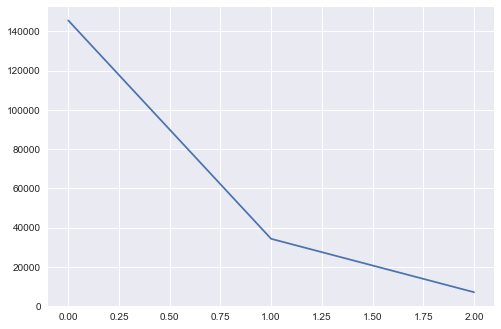

In [9]:
#lets combine the latent variables with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(X_prime)
    
plt.plot(pca.explained_variance_)
plt.show()

X_prime = pca.transform(X_prime)
X_test_prime = pca.transform(X_test_prime)

In [10]:
#add the original variables to the features set
X_prime = np.column_stack((X,X_prime))
X_test_prime = np.column_stack((X_test,X_test_prime))

In [11]:
from keras.layers import Input, Dense, Flatten
from keras.models import Model, Sequential

def get_acc(predict,y):
    return np.sum((predict>0.5).astype(np.int)==y)/len(y)

Using TensorFlow backend.


In [12]:
#model with latent variable PCA components
input_data = Input(shape=(X_prime.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X_prime, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test_prime, y_test))


Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5913 - val_loss: 0.5682
Epoch 2/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5625 - val_loss: 0.5563
Epoch 3/100
124999/124999 [==============================] - 0s 4us/step - loss: 0.5511 - val_loss: 0.5467
Epoch 4/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5422 - val_loss: 0.5384
Epoch 5/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5351 - val_loss: 0.5321
Epoch 6/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5293 - val_loss: 0.5256
Epoch 7/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5250 - val_loss: 0.5209
Epoch 8/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5195 - val_loss: 0.5174
Epoch 9/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5145 - va

In [13]:
p_test = model.predict(X_test_prime)
p_train = model.predict(X_prime)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.8203694370445036, 0.82114256914055317)

In [14]:
#model without latent variable PCA components
input_data = Input(shape=(X.shape[1],))
layer1 = Dense(200, activation='sigmoid')(input_data)
layer2 = Dense(1, activation='sigmoid')(layer1)
model = Model(input_data, layer2)

model.compile(optimizer='adagrad', 
                    loss='binary_crossentropy')
model.fit(X, y,
                epochs=100,
                batch_size=5000,
                shuffle=False,
                validation_data=(X_test, y_test))

Train on 124999 samples, validate on 125001 samples
Epoch 1/100
124999/124999 [==============================] - 1s 5us/step - loss: 0.5870 - val_loss: 0.5686
Epoch 2/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5583 - val_loss: 0.5533
Epoch 3/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5523 - val_loss: 0.5524
Epoch 4/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5463 - val_loss: 0.5416
Epoch 5/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5410 - val_loss: 0.5379
Epoch 6/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5364 - val_loss: 0.5348
Epoch 7/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5336 - val_loss: 0.5297
Epoch 8/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5301 - val_loss: 0.5256
Epoch 9/100
124999/124999 [==============================] - 0s 3us/step - loss: 0.5265 - va

In [15]:
p_test = model.predict(X_test)
p_train = model.predict(X)
get_acc(p_test,y_test),get_acc(p_train,y)

(0.8008655930752554, 0.8031184249473996)